In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN
from imblearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import adam
import tensorflow as tf

import seaborn as sn
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Anmol_Temp.csv')

X = df[['CHI Score Month 0', 'CHI Score 0-1', 'Support Cases Month 0',
       'Support Cases 0-1', 'SP Month 0', 'SP 0-1', 'Logins 0-1',
       'Blog Articles 0-1', 'Views 0-1', ' Days Since Last Login 0-1',
       'Group_14-67', 'Group_2-6', 'Group_6-14']]
y = df['Churn (1 = Yes, 0 = No)']
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### Compare different oversampling techniques

Ref :https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py

As seen in plot below we will use SMOTE later below for tackling imblance data

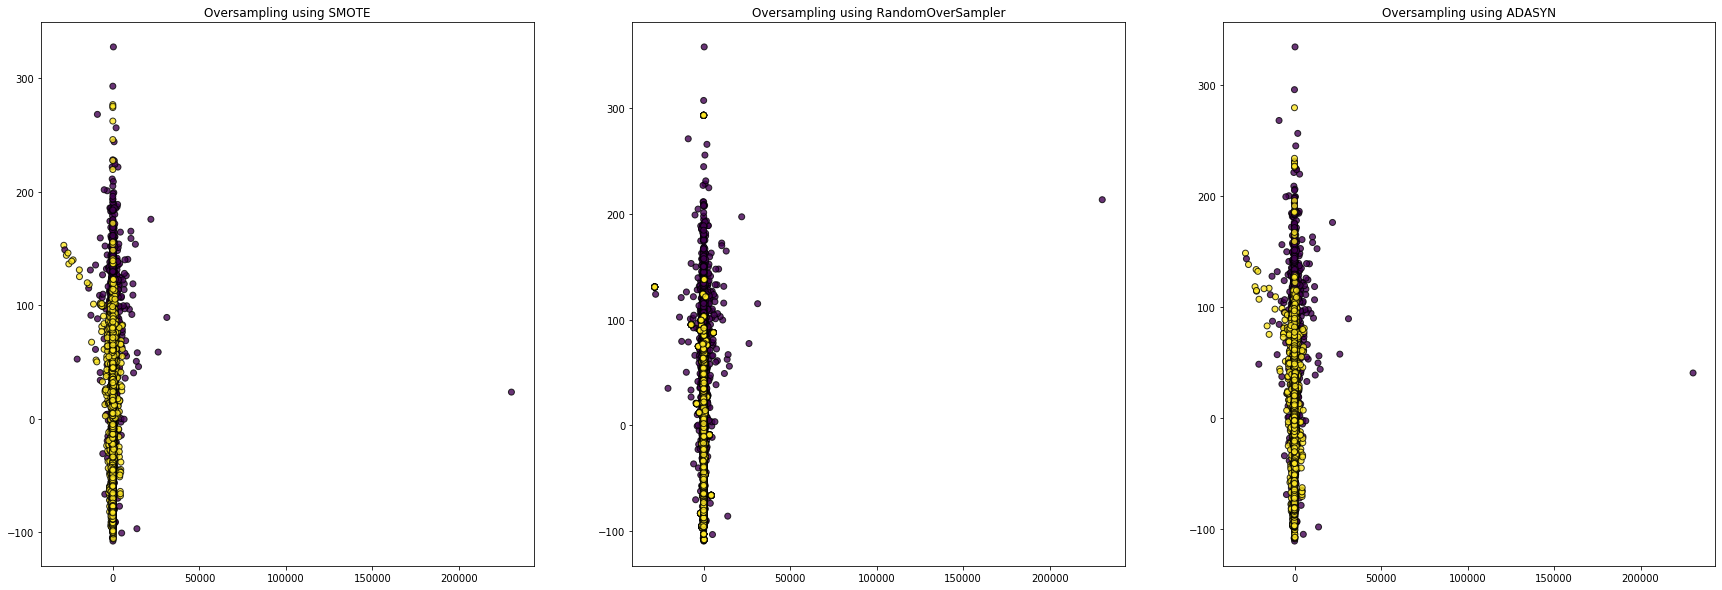

In [3]:
def plot_resampling(X, y, sampling, ax):
    X_rs, y_rs = sampling.fit_resample(X, y)
    #do PCA on features to plot and visualize
    pca = PCA(n_components=2)
    X_rs = pca.fit_transform(X_rs)
    ax.scatter(X_rs[:, 0], X_rs[:, 1], c=y_rs, alpha=0.8, edgecolor='k')
    return Counter(y_rs)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(30, 10))
ax_arr = (ax1, ax2, ax3)
for ax, sampler in zip(ax_arr, (
        SMOTE(random_state=12345),
        RandomOverSampler(random_state=12345),
        ADASYN(random_state=12345))):
    pipeline = make_pipeline(sampler, LinearSVC())
    pipeline.fit(X, y)
    plot_resampling(X, y, sampler, ax)
    ax.set_title('Oversampling using {}'.format(
        sampler.__class__.__name__))
plt.show()

## Applying various Models for solving the Binary CLassification Problem in hand (Fraud Detection)

### Splitting the data into Train and test in 80:20 Ratio

In [4]:
X = df[['CHI Score Month 0', 'CHI Score 0-1', 'Support Cases Month 0',
       'Support Cases 0-1', 'SP Month 0', 'SP 0-1', 'Logins 0-1',
       'Blog Articles 0-1', 'Views 0-1', ' Days Since Last Login 0-1',
       'Group_14-67', 'Group_2-6', 'Group_6-14']]
Y = df['Churn (1 = Yes, 0 = No)']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=12345)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_train.value_counts())
print(Y_test.value_counts())

(4465, 13)
(1117, 13)
(4465,)
(1117,)
0    4195
1     270
Name: Churn (1 = Yes, 0 = No), dtype: int64
0    1065
1      52
Name: Churn (1 = Yes, 0 = No), dtype: int64


### Standardizing the data 

In [5]:
X_train_std = StandardScaler(with_mean=False)
# here it will learn mu and sigma
X_train_std.fit(X_train)

## Training Set
X_train = X_train_std.transform(X_train)
## Testing set
X_test = X_train_std.transform(X_test)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4465, 13)
(1117, 13)
(4465,)
(1117,)


<h2> <font color = blue> Without Oversampling (Imbalanced Classes)

### Function to Train data and do crossvalidation and selection of best hyperparameter

In [6]:
def call_model(model,final_xtr, ytr):

    if model == 1: #Logistic Regression
        penalty = 'l2'
        grid_values = {'penalty': [penalty], 'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]}   
        clf = GridSearchCV(LogisticRegression(), param_grid= grid_values, cv=5,return_train_score=True,
                           scoring= 'roc_auc')
        clf.fit(final_xtr, ytr)
        c = clf.best_params_['C']
        print('Best value of C(1/lambda) = ',c)
   
    elif model == 2: #Random Forest
        parameters = {
        'n_estimators'      : [50,100,200,300,500]
        }

        clf = GridSearchCV(RandomForestClassifier(), parameters, cv=5,return_train_score=True,
                           scoring= 'roc_auc')

        clf.fit(final_xtr, ytr)
        c = clf.best_params_['n_estimators']
        print('Best value of n_estimators = ',c)

    elif model == 3:    ## SVM
        gammas = [0.001, 0.01, 0.1, 1]
        parameters = {'gamma' : gammas}

        clf = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5,return_train_score=True,
                           scoring= 'roc_auc')

        clf.fit(final_xtr, ytr)
        c = clf.best_params_['gamma']
        print('Best value of gamma = ',c)
        
    elif model == 4: #KNN
        n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17]
        parameters = {'n_neighbors' : n_neighbors}

        clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=5,return_train_score=True,
                           scoring= 'roc_auc')
        clf.fit(final_xtr, ytr)
        c = clf.best_params_['n_neighbors']
        print('Best value of n_neighbors = ',c)
        

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    cv_scores_tr = clf.cv_results_['mean_train_score']
    cv_scores_cv = clf.cv_results_['mean_test_score']
    return cv_scores_tr, cv_scores_cv, c    

### Function to test the model

In [7]:
def test_acc(model,optimal_c,final_xtr, ytr,final_xtest,ytest):
    
    if model == 1:
        penalty = 'l2'
        ## Logistic Regression
        clf_optimal = LogisticRegression(C=optimal_c,penalty=penalty)
    elif model == 2:
        ## Random Forest
        clf_optimal = RandomForestClassifier(n_estimators=optimal_c)
    elif model == 3:
        ## SVM
        clf_optimal = SVC(C=optimal_c, kernel='rbf',probability=True)
    elif model == 4:
        ## KNN
        clf_optimal = KNeighborsClassifier(n_neighbors=optimal_c)
        
    ## IDentifying the True Positive, True Negative, False Positive and False NEgative    
    clf_optimal.fit(final_xtr, ytr)
    pred_prob_ts = clf_optimal.predict_proba(final_xtest).T[1]
    fpr_ts, tpr_ts, threshold = roc_curve(ytest, pred_prob_ts)     
    pred_prob_tr = clf_optimal.predict_proba(final_xtr).T[1]
    fpr_tr, tpr_tr, threshold = roc_curve(ytr, pred_prob_tr)     
    pred = clf_optimal.predict(final_xtest)    

    return clf_optimal,pred, fpr_ts, tpr_ts, fpr_tr, tpr_tr

### Function to plot AUC curve for Training and Validation data

In [8]:
def train_val_auc(cv_scores_tr, cv_scores_cv,hg):

    tt = np.round(np.log(hg),2)
    tt

    auclist = np.arange(0.7,1.1,0.1)
    fig = plt.figure(figsize= (28,18))
    plt.grid(b=True, which='major', color='grey', linestyle='-')

    plt.plot(tt, cv_scores_cv, 'b', label='Validation AUC')
    plt.plot(tt, cv_scores_tr, 'r', label='Training AUC')
    plt.xlabel('Alpha')
    plt.ylabel('Area under ROC Curve')
    plt.xticks(tt,hg)
    plt.yticks(auclist)

    plt.legend(loc="lower right",prop={'size': 24})
    plt.show()


### Function to plot ROC-AUC Curve for Train and Validation data

In [9]:
def roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr):

    import matplotlib.pyplot as plt

    roc_auc_ts = auc(fpr_ts, tpr_ts)
    roc_auc_tr = auc(fpr_tr, tpr_tr)

    fig = plt.figure(figsize= (18,8))
    plt.grid(b=True, which='major', color='grey', linestyle='-')
    plt.plot(fpr_ts, tpr_ts, color='darkorange', lw=1, label='Test ROC curve (area = %0.3f)' % roc_auc_ts)
    plt.plot(fpr_tr, tpr_tr, color='red', lw=1, label='Training ROC curve (area = %0.3f)' % roc_auc_tr)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right",prop={'size': 22})
    plt.show()

### Function to plot Confusion Matrix

In [10]:
def conf_mat(pred,ytest):
    
    
    labels = ['Not Fraud','Fraud']

    ## Accuracy
    cm_lr = confusion_matrix(ytest,pred)
    ## Precision
    rc =(((cm_lr.T)/(cm_lr.sum(axis=1))).T)
    ## Recall
    pr =(cm_lr/cm_lr.sum(axis=0))
    cm = cm_lr
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    
    sk_recall = recall_score(ytest,pred, average='macro')
    sk_precision = precision_score(ytest,pred ,average='macro')
    
    #label size setting
    sn.set(font_scale=1.5)
    
    print("-"*20, "Confusion matrix", "-"*20)
    #plotting using heatmap for total count
    cm_lrdf = pd.DataFrame(cm_lr, range(2),range(2))
    plt.figure(figsize=(5,5))
    sn.heatmap(cm_lrdf, annot=True, cmap="YlGn", fmt=".3f", xticklabels=labels, yticklabels=labels)
   
    
    plt.xlabel('Original Class')
    plt.ylabel('Predicted Class')
    plt.autoscale()
    plt.show()
    
    print("-"*20, "Precision matrix  (Col Sum=1)", "-"*20)
    #plotting using heatmap for Precision
    cm_prdf = pd.DataFrame(pr, range(2),range(2))
    plt.figure(figsize=(5,5))
    sn.heatmap(cm_prdf, annot=True, cmap="YlGn", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Original Class')
    plt.ylabel('Predicted Class')
    plt.autoscale()
    plt.show()
    
    print("-"*20, "Recall matrix  (Row Sum=1) -", "-"*20)
    #plotting using heatmap for total count
    cm_rcdf = pd.DataFrame(rc, range(2),range(2))
    plt.figure(figsize=(5,5))
    sn.heatmap(cm_rcdf, annot=True, cmap="YlGn", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Original Class')
    plt.ylabel('Predicted Class')
    plt.autoscale()
    plt.show()
    
    cm_prdf = np.nan_to_num(cm_prdf)
    cm_rcdf = np.nan_to_num(cm_rcdf)   
    pr = np.nan_to_num(pr)
    rc = np.nan_to_num(rc)
    
    
    confmat_summary = pd.DataFrame({
'Not Fraud': [cm_prdf[0][0],cm_rcdf[0][0], (2*cm_prdf[0][0]*cm_rcdf[0][0])/(cm_prdf[0][0] + cm_rcdf[0][0])],
'Fraud': [cm_prdf[1][1],cm_rcdf[1][1],(2*cm_prdf[1][1]*cm_rcdf[1][1])/(cm_prdf[1][1] + cm_rcdf[1][1])]},
index=['Precision','Recall','F1-Score'])
    
    #print(classification_report(ytest, pred, labels=[0,1]))
    
    print(confmat_summary)



### Function to plot Precision-Recall Curve

In [11]:
def pr_recall_curve(Y_test, pred):
    precision, recall, thresholds_pr = precision_recall_curve(Y_test, pred)
    AUC_PRcurve= auc(recall, precision)
    plt.figure(1)
    #plot PR curve
    plt.plot(precision, recall, label = "AUC = {:0.2f}".format(AUC_PRcurve))
    plt.xlabel('Precision', fontsize = 14)
    plt.ylabel('Recall', fontsize = 14)
    plt.title('Precision-Recall Curve', fontsize = 18)
    plt.legend(loc='best')
    plt.show()

<h2> <font color = blue> 1. Logistic Regression

In [12]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(1,X_train, Y_train)

Best value of C(1/lambda) =  10.0
0.682 (+/-0.061) for {'C': 1e-05, 'penalty': 'l2'}
0.682 (+/-0.062) for {'C': 0.0001, 'penalty': 'l2'}
0.684 (+/-0.065) for {'C': 0.001, 'penalty': 'l2'}
0.690 (+/-0.069) for {'C': 0.01, 'penalty': 'l2'}
0.692 (+/-0.068) for {'C': 0.1, 'penalty': 'l2'}
0.692 (+/-0.067) for {'C': 1.0, 'penalty': 'l2'}
0.692 (+/-0.066) for {'C': 10.0, 'penalty': 'l2'}
0.692 (+/-0.066) for {'C': 100.0, 'penalty': 'l2'}
0.692 (+/-0.066) for {'C': 1000.0, 'penalty': 'l2'}
0.692 (+/-0.066) for {'C': 10000.0, 'penalty': 'l2'}
0.692 (+/-0.066) for {'C': 100000.0, 'penalty': 'l2'}


<h3> 'Training - Validation' AUC </h2>

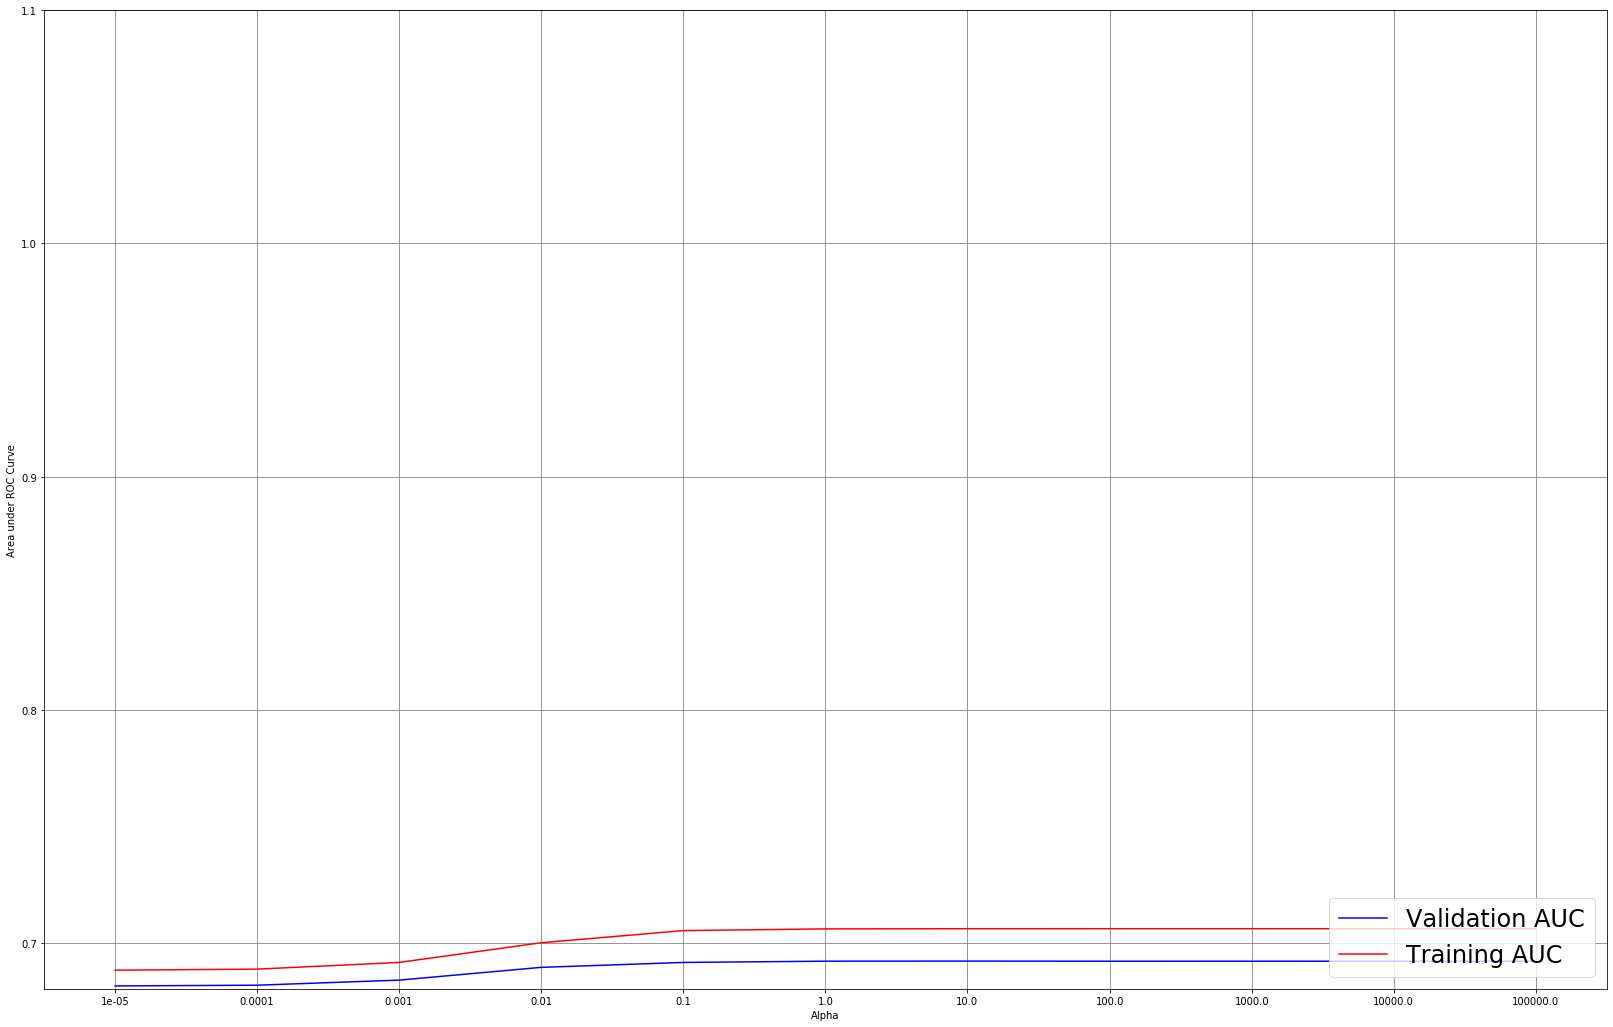

In [13]:
lambdalistorg = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [14]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(1,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

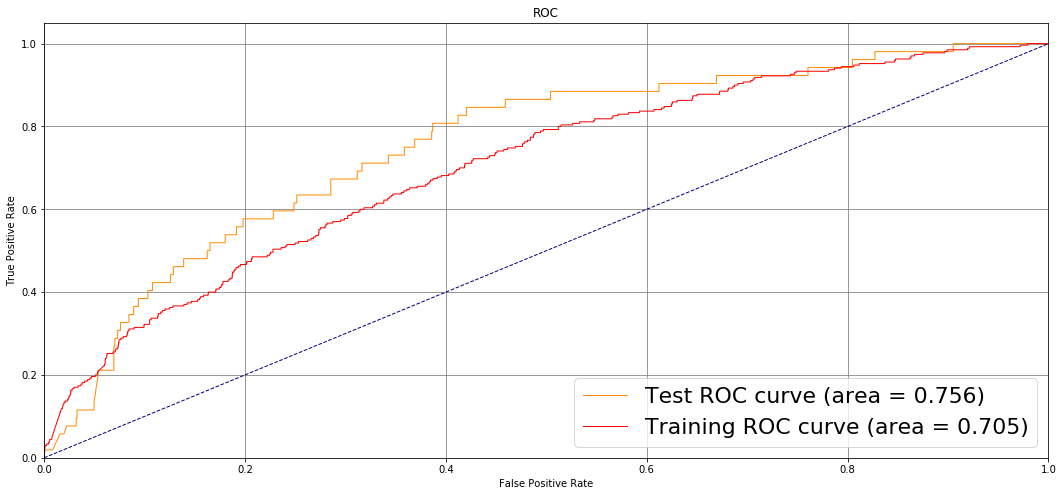

In [15]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


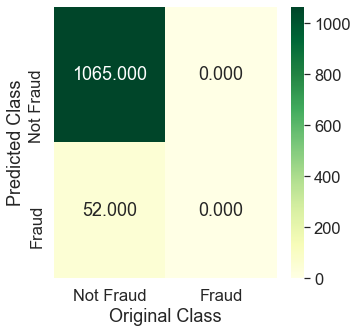

-------------------- Precision matrix  (Col Sum=1) --------------------


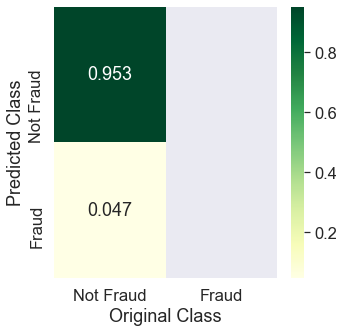

-------------------- Recall matrix  (Row Sum=1) - --------------------


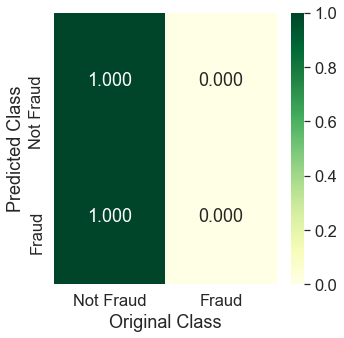

           Not Fraud  Fraud
Precision   0.953447    0.0
Recall      1.000000    0.0
F1-Score    0.976169    NaN


In [16]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

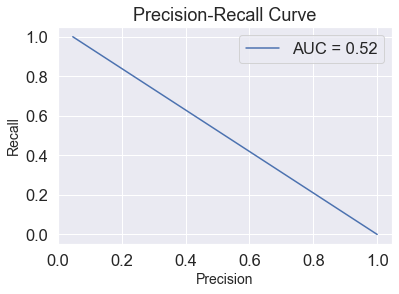

In [17]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 2. Random Forest
    

In [18]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_t= call_model(2,X_train, Y_train)

Best value of n_estimators =  200
0.608 (+/-0.064) for {'n_estimators': 50}
0.629 (+/-0.057) for {'n_estimators': 100}
0.630 (+/-0.067) for {'n_estimators': 200}
0.621 (+/-0.061) for {'n_estimators': 300}
0.621 (+/-0.059) for {'n_estimators': 500}


<h3> 'Training - Validation' AUC </h2>

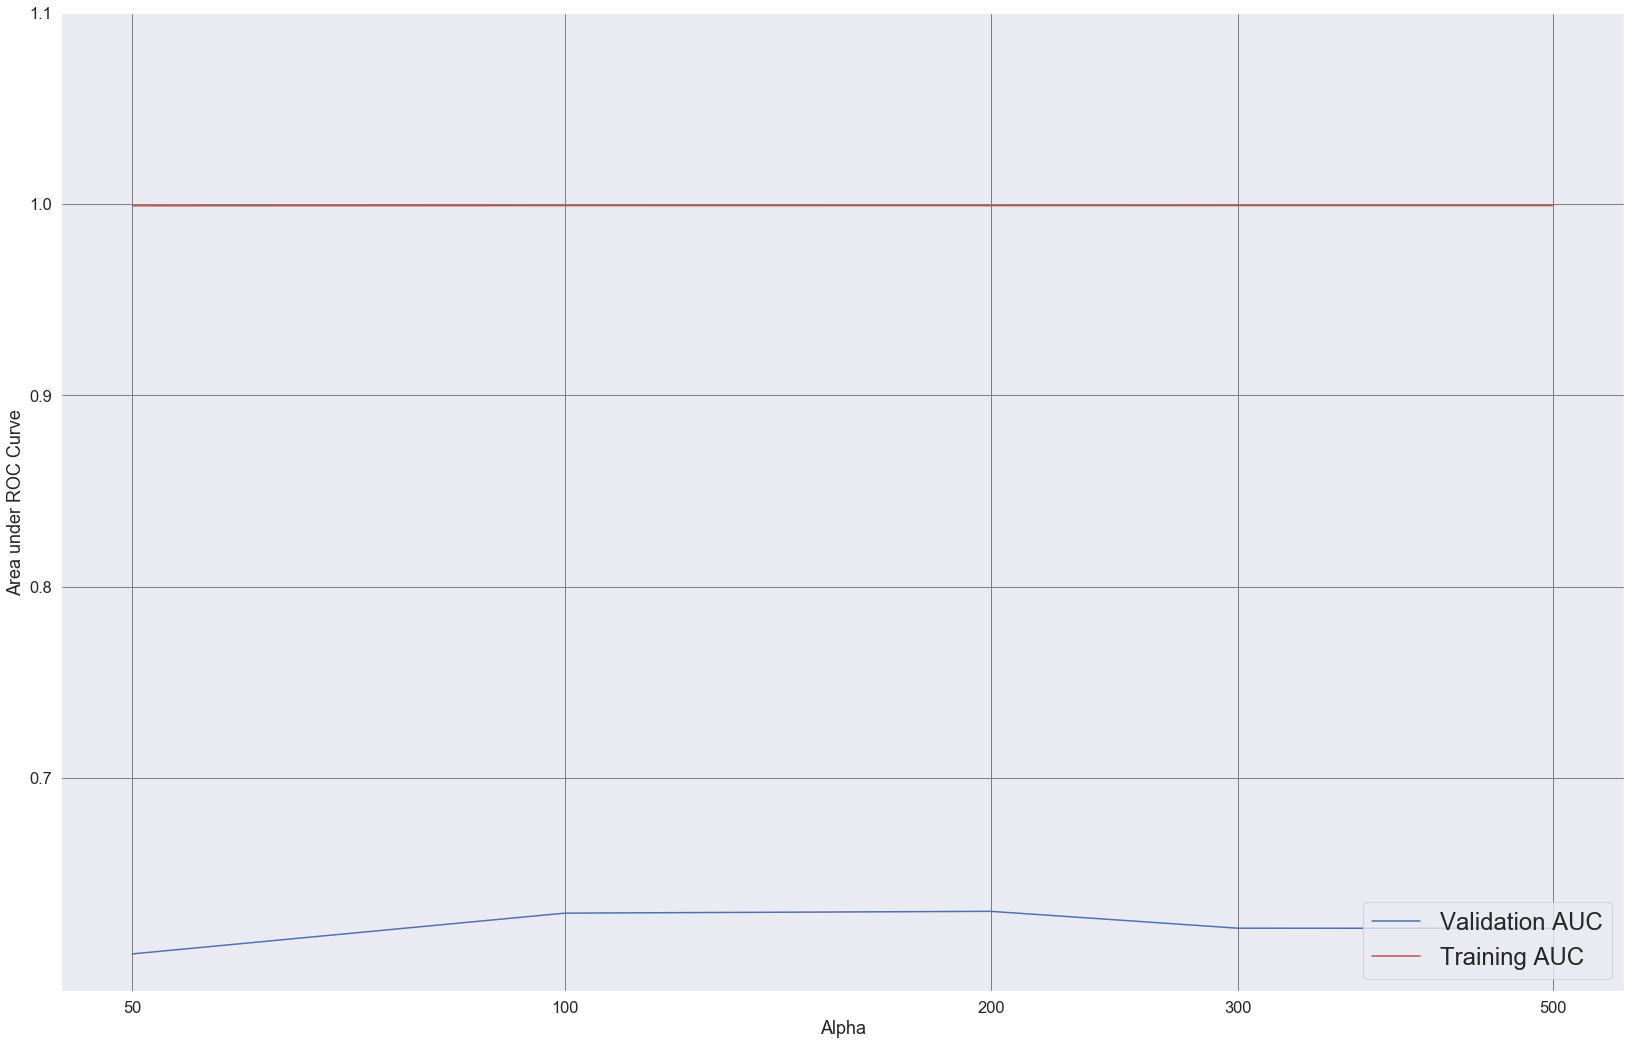

In [19]:
lambdalistorg = [50,100,200,300,500]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [20]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(2,optimal_t,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

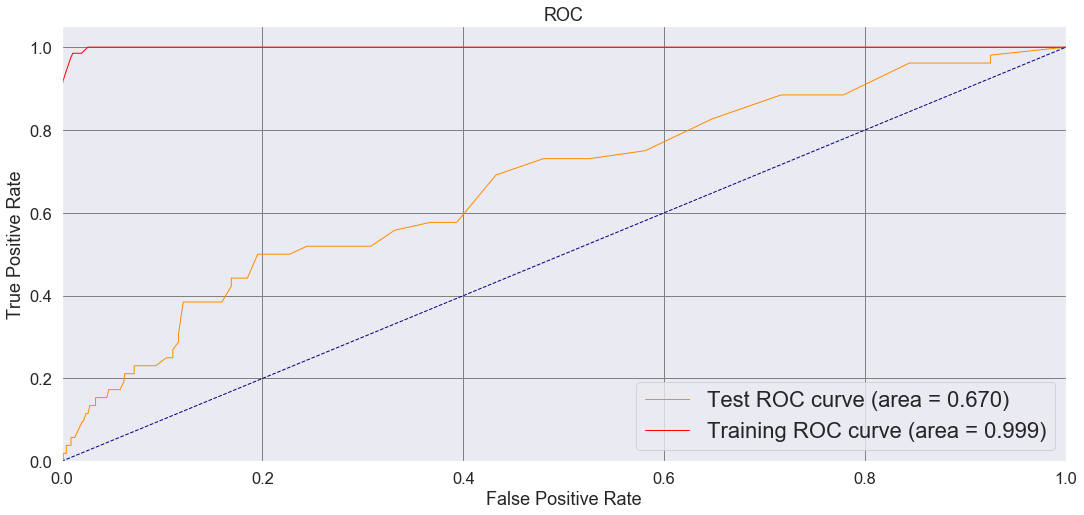

In [21]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


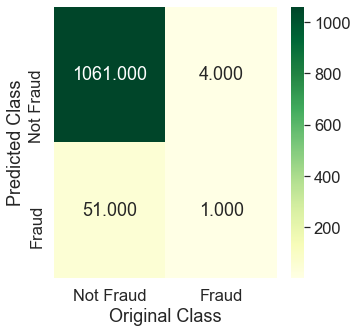

-------------------- Precision matrix  (Col Sum=1) --------------------


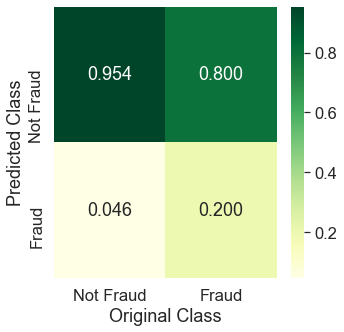

-------------------- Recall matrix  (Row Sum=1) - --------------------


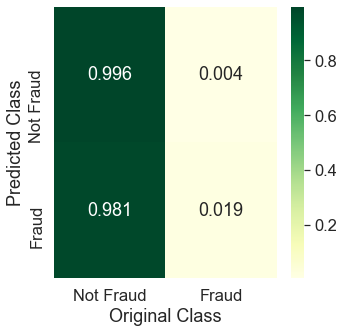

           Not Fraud     Fraud
Precision   0.954137  0.200000
Recall      0.996244  0.019231
F1-Score    0.974736  0.035088


In [22]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

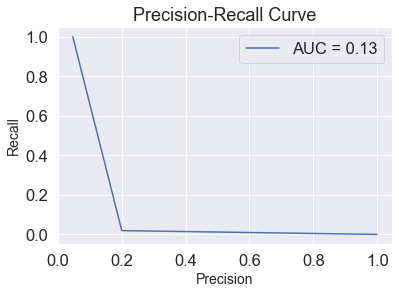

In [23]:
pr_recall_curve(Y_test, pred)

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
f1_score(Y_test, pred)

0.03508771929824562

<h2> <font color = blue> 3. SVM

In [25]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(3,X_train, Y_train)

Best value of gamma =  0.1
0.486 (+/-0.130) for {'gamma': 0.001}
0.569 (+/-0.050) for {'gamma': 0.01}
0.571 (+/-0.069) for {'gamma': 0.1}
0.531 (+/-0.050) for {'gamma': 1}


<h3> 'Training - Validation' AUC </h2>

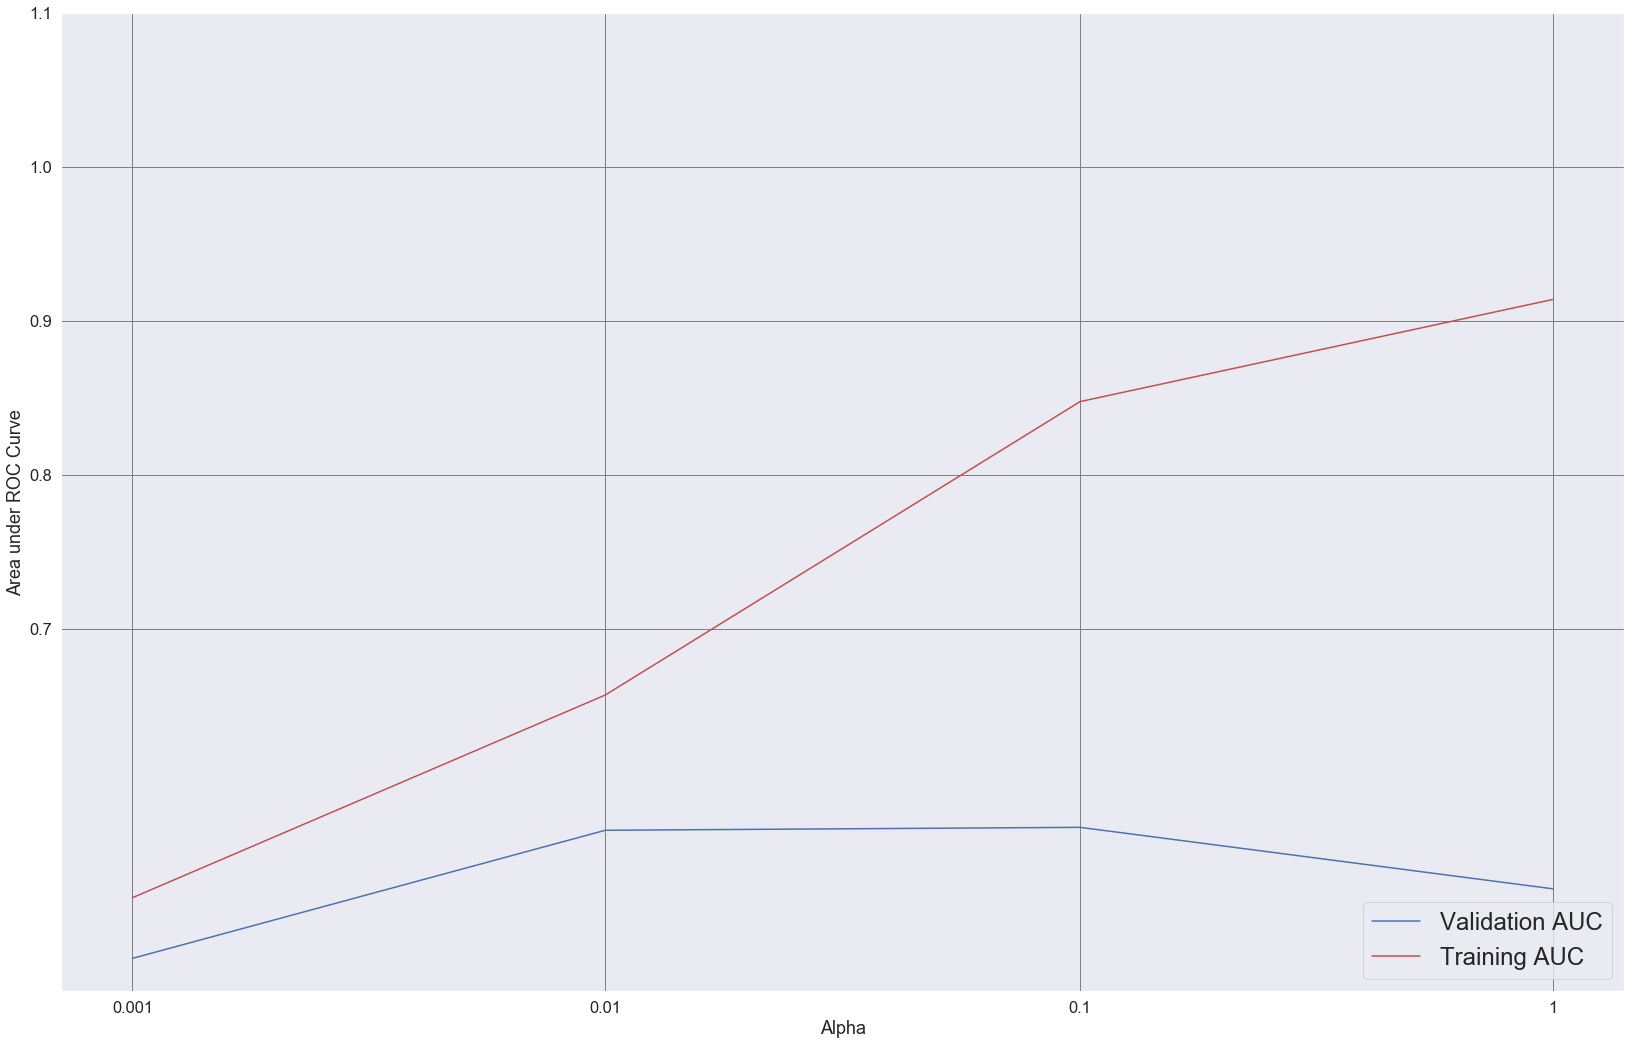

In [26]:
lambdalistorg = [0.001, 0.01, 0.1, 1]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [27]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(3,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

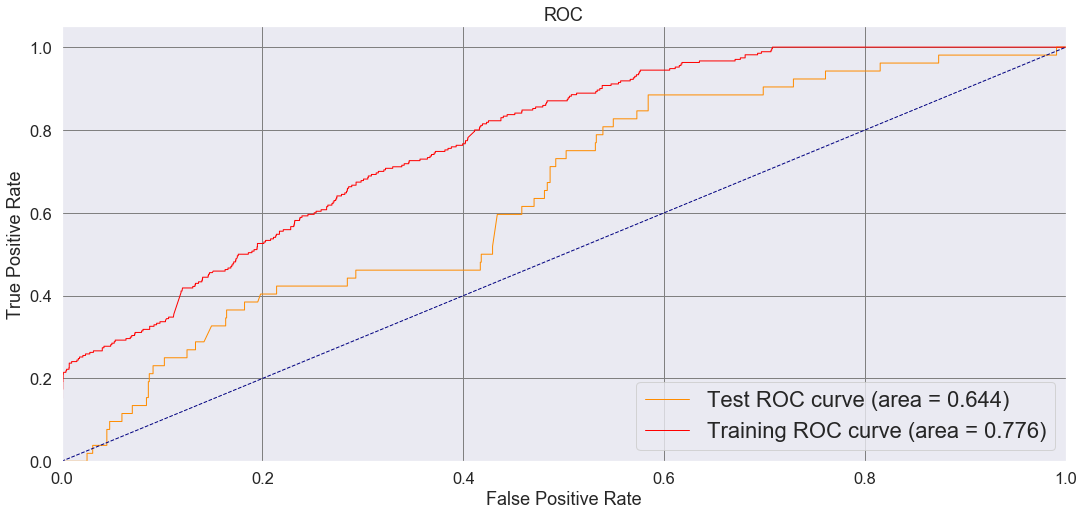

In [28]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


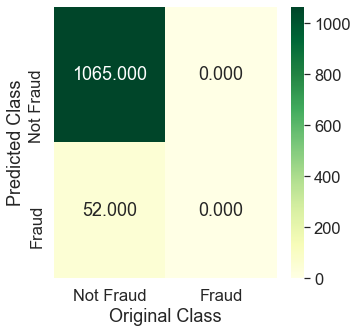

-------------------- Precision matrix  (Col Sum=1) --------------------


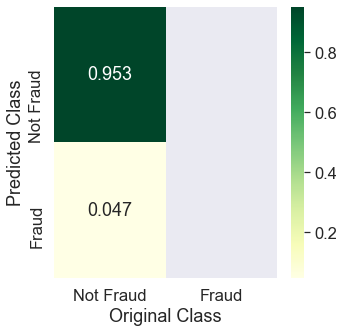

-------------------- Recall matrix  (Row Sum=1) - --------------------


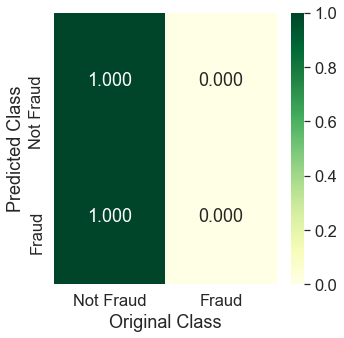

           Not Fraud  Fraud
Precision   0.953447    0.0
Recall      1.000000    0.0
F1-Score    0.976169    NaN


In [29]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

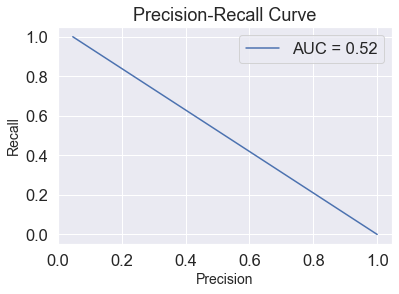

In [30]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 4. KNN

In [31]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(4,X_train, Y_train)

Best value of n_neighbors =  17
0.528 (+/-0.040) for {'n_neighbors': 1}
0.538 (+/-0.053) for {'n_neighbors': 3}
0.560 (+/-0.035) for {'n_neighbors': 5}
0.571 (+/-0.051) for {'n_neighbors': 7}
0.594 (+/-0.065) for {'n_neighbors': 9}
0.599 (+/-0.080) for {'n_neighbors': 11}
0.602 (+/-0.071) for {'n_neighbors': 13}
0.620 (+/-0.059) for {'n_neighbors': 15}
0.633 (+/-0.069) for {'n_neighbors': 17}


<h3> 'Training - Validation' AUC </h2>

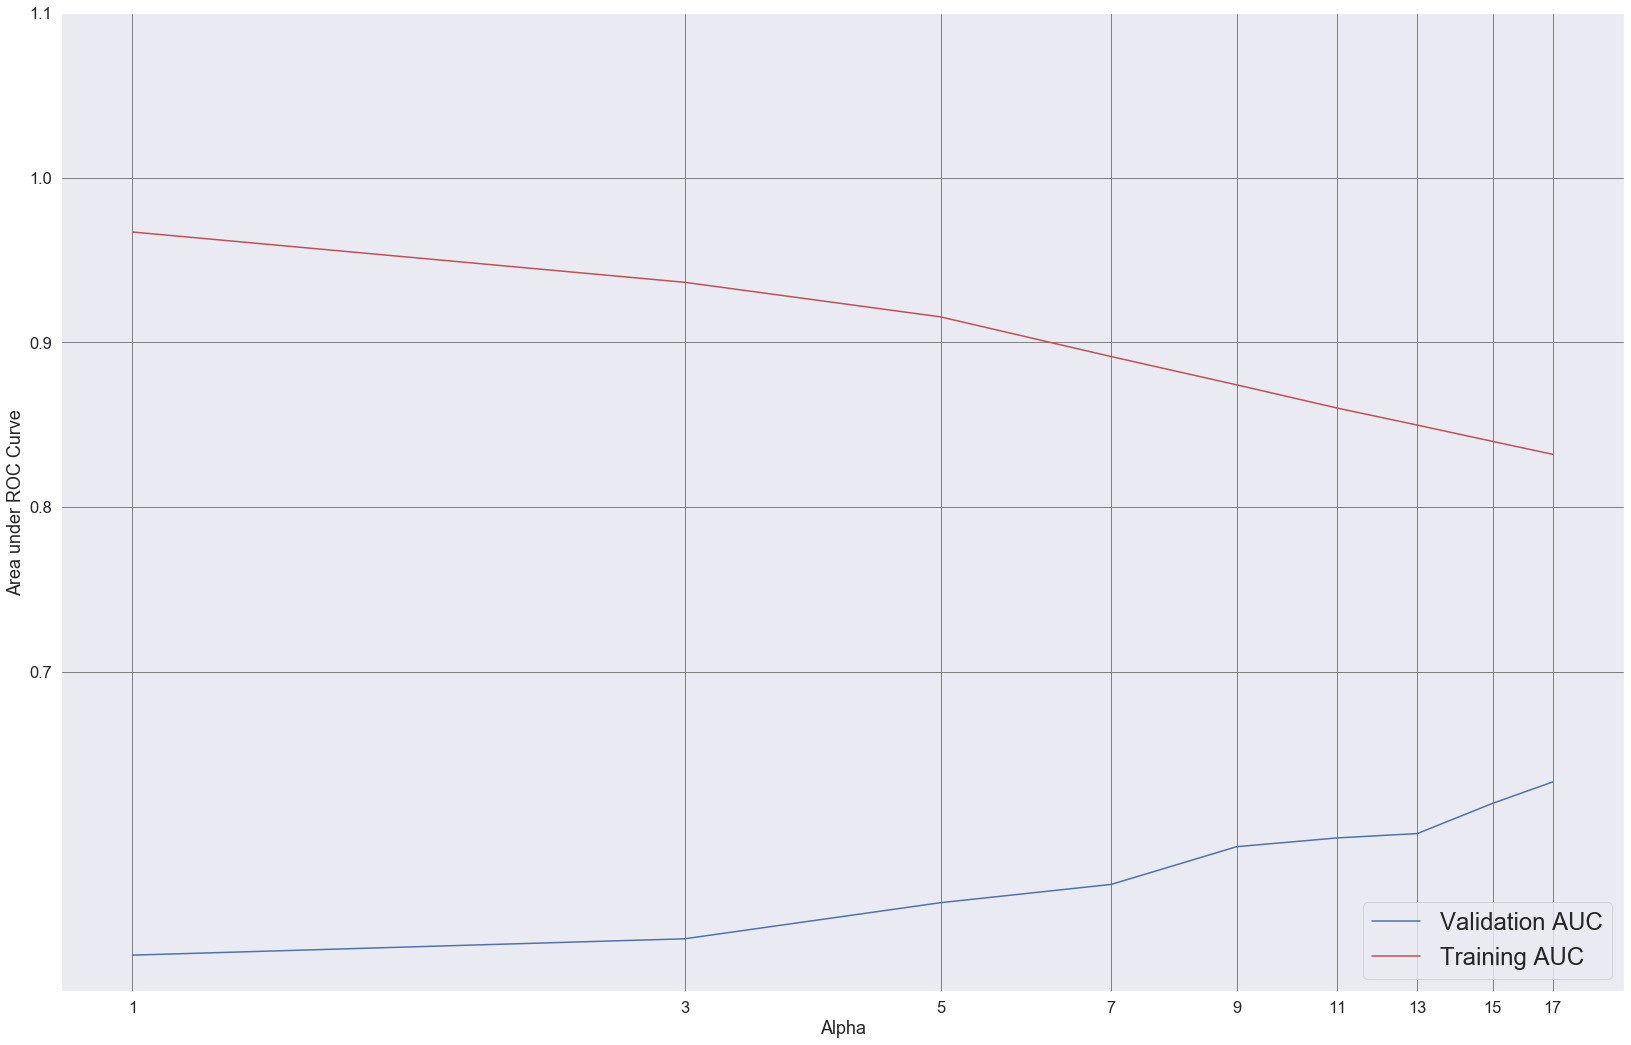

In [32]:
lambdalistorg = [1, 3, 5, 7, 9, 11, 13, 15, 17]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [33]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(4,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

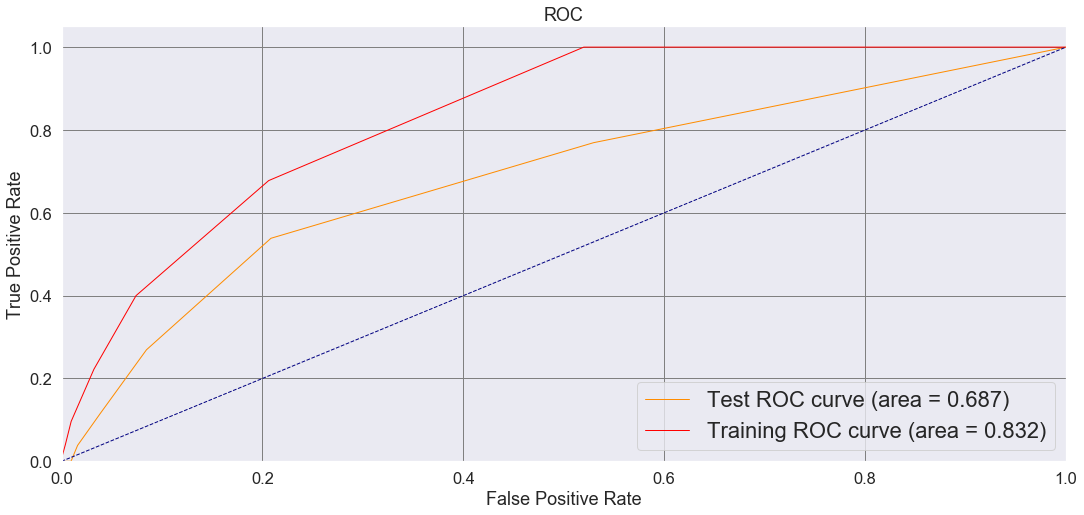

In [34]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


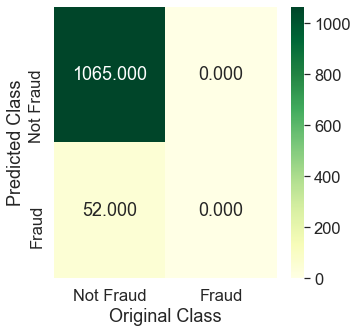

-------------------- Precision matrix  (Col Sum=1) --------------------


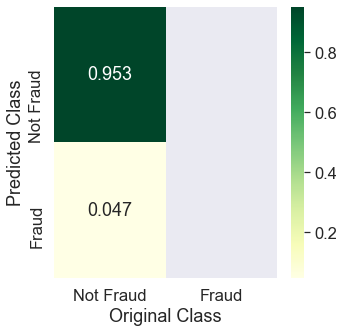

-------------------- Recall matrix  (Row Sum=1) - --------------------


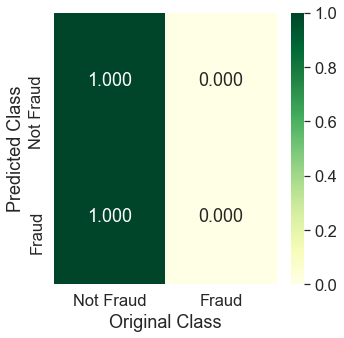

           Not Fraud  Fraud
Precision   0.953447    0.0
Recall      1.000000    0.0
F1-Score    0.976169    NaN


In [35]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

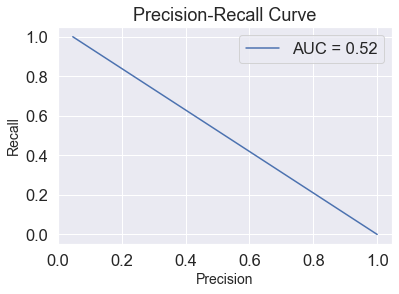

In [36]:
pr_recall_curve(Y_test, pred)

<h2> <font color = maroon> With Oversampling (Balanced Classes)

## <font color = blue> **Oversampling** </font> for correcting class imbalance

In [40]:
X = df[['CHI Score Month 0', 'CHI Score 0-1', 'Support Cases Month 0',
       'Support Cases 0-1', 'SP Month 0', 'SP 0-1', 'Logins 0-1',
       'Blog Articles 0-1', 'Views 0-1', ' Days Since Last Login 0-1',
       'Group_14-67', 'Group_2-6', 'Group_6-14']]
Y = df['Churn (1 = Yes, 0 = No)']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=12345)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_train.value_counts())
print(Y_test.value_counts())

(4465, 13)
(1117, 13)
(4465,)
(1117,)
0    4195
1     270
Name: Churn (1 = Yes, 0 = No), dtype: int64
0    1065
1      52
Name: Churn (1 = Yes, 0 = No), dtype: int64


### Applying SMOTE to oversample the data

In [41]:
from imblearn.over_sampling import SMOTE
ros = SMOTE(random_state=42)
X_train, Y_train = ros.fit_resample(X_train, Y_train)
print(pd.Series(Y_train).value_counts())

1    4195
0    4195
Name: Churn (1 = Yes, 0 = No), dtype: int64


<h2> <font color = blue> 1. Logistic Regression

In [42]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(1,X_train, Y_train)

Best value of C(1/lambda) =  100000.0
0.679 (+/-0.018) for {'C': 1e-05, 'penalty': 'l2'}
0.686 (+/-0.023) for {'C': 0.0001, 'penalty': 'l2'}
0.730 (+/-0.012) for {'C': 0.001, 'penalty': 'l2'}
0.752 (+/-0.027) for {'C': 0.01, 'penalty': 'l2'}
0.764 (+/-0.039) for {'C': 0.1, 'penalty': 'l2'}
0.779 (+/-0.044) for {'C': 1.0, 'penalty': 'l2'}
0.773 (+/-0.043) for {'C': 10.0, 'penalty': 'l2'}
0.771 (+/-0.043) for {'C': 100.0, 'penalty': 'l2'}
0.777 (+/-0.056) for {'C': 1000.0, 'penalty': 'l2'}
0.780 (+/-0.039) for {'C': 10000.0, 'penalty': 'l2'}
0.784 (+/-0.061) for {'C': 100000.0, 'penalty': 'l2'}


<h3> 'Training - Validation' AUC </h2>

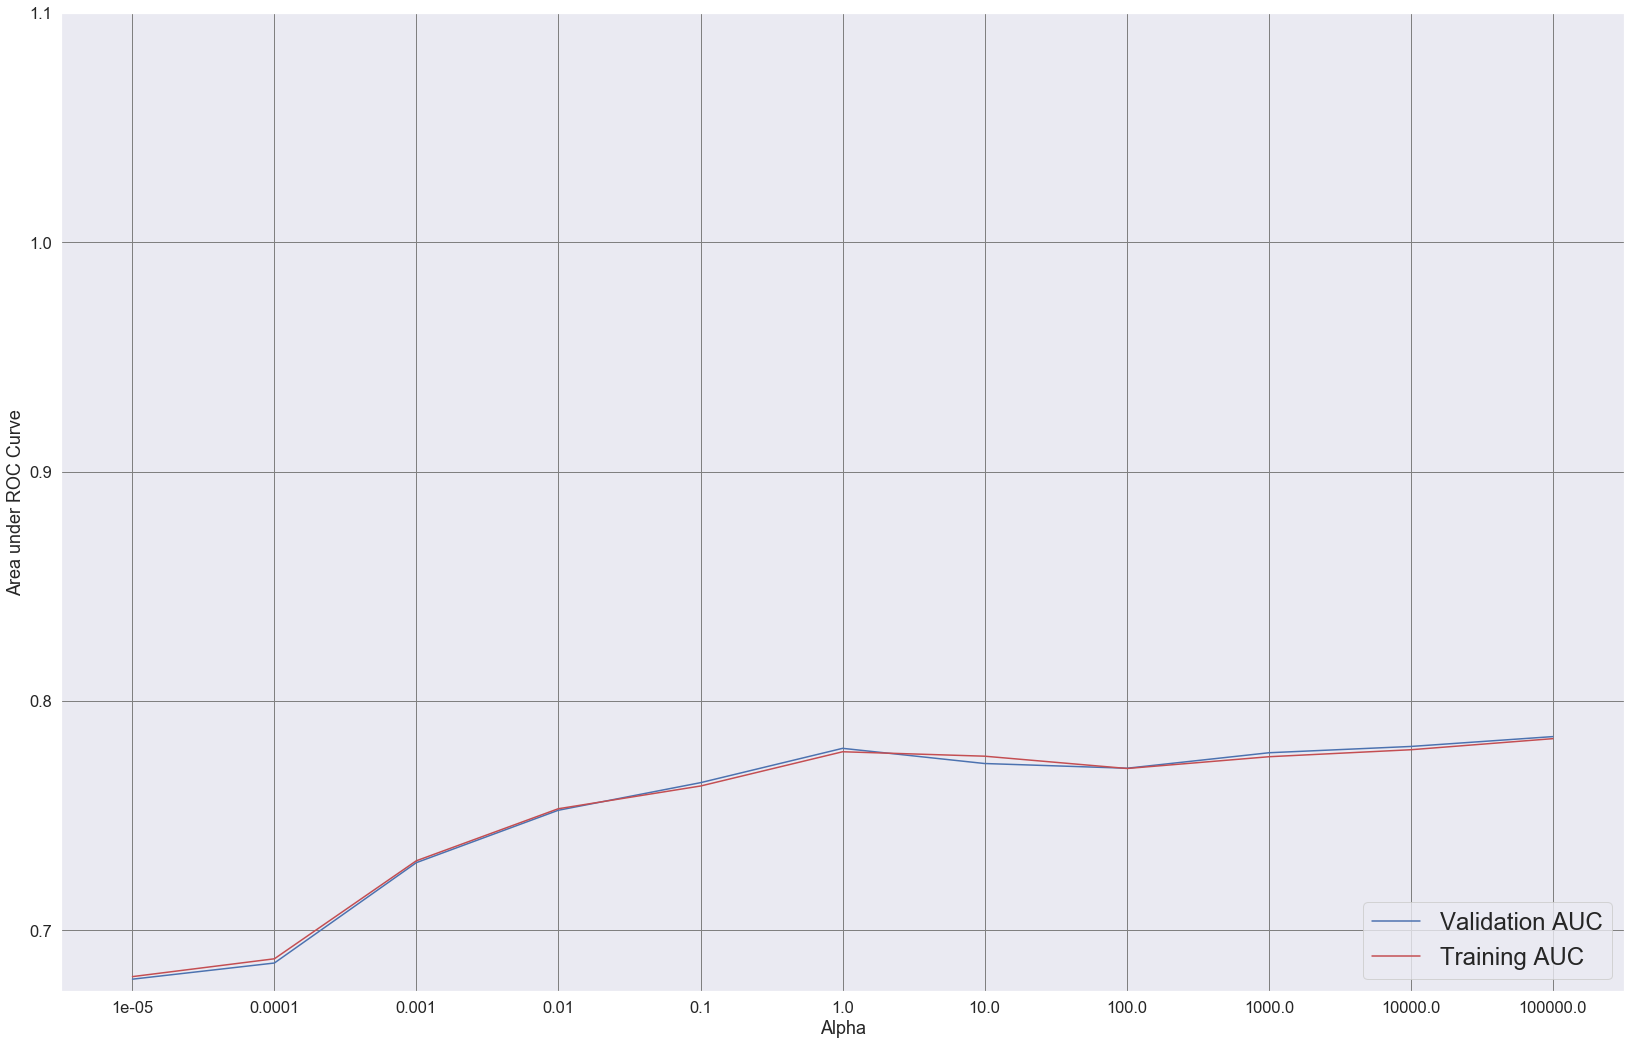

In [43]:
lambdalistorg = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [44]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(1,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

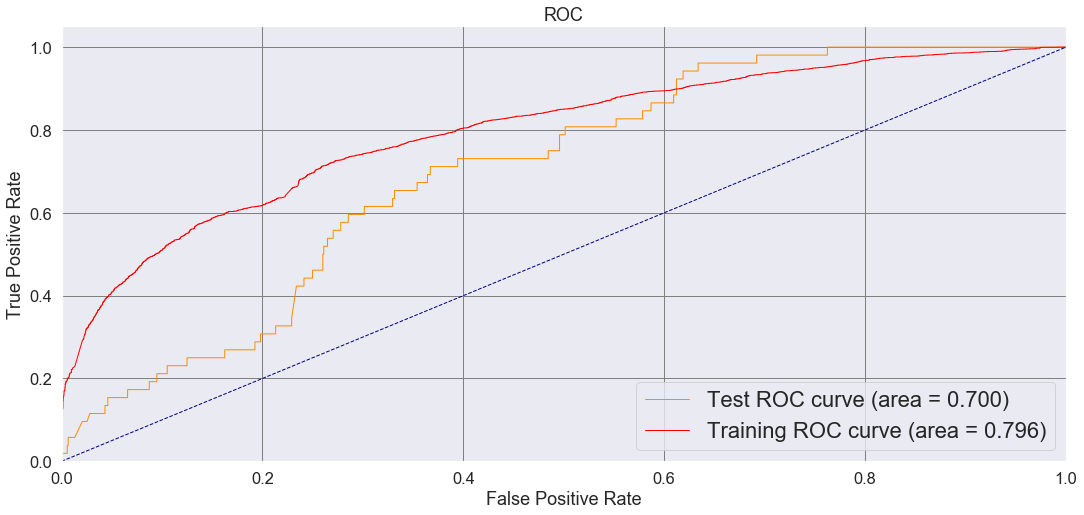

In [45]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


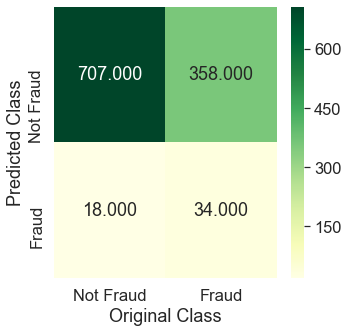

-------------------- Precision matrix  (Col Sum=1) --------------------


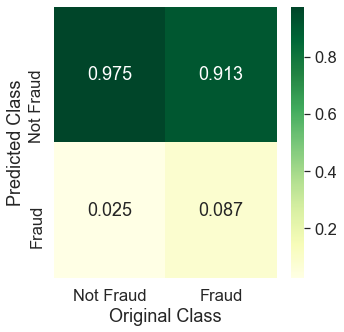

-------------------- Recall matrix  (Row Sum=1) - --------------------


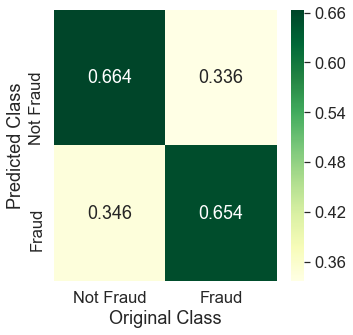

           Not Fraud     Fraud
Precision   0.975172  0.086735
Recall      0.663850  0.653846
F1-Score    0.789944  0.153153


In [46]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

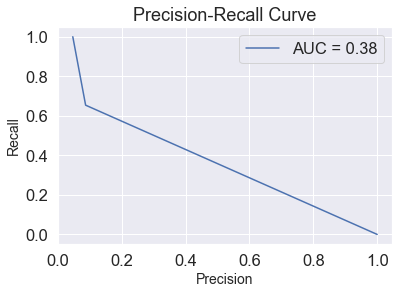

In [47]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 2. Random Forest
    

In [48]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_t= call_model(2,X_train, Y_train)

Best value of n_estimators =  200
0.984 (+/-0.030) for {'n_estimators': 50}
0.985 (+/-0.029) for {'n_estimators': 100}
0.985 (+/-0.029) for {'n_estimators': 200}
0.984 (+/-0.030) for {'n_estimators': 300}
0.985 (+/-0.029) for {'n_estimators': 500}


<h3> 'Training - Validation' AUC </h2>

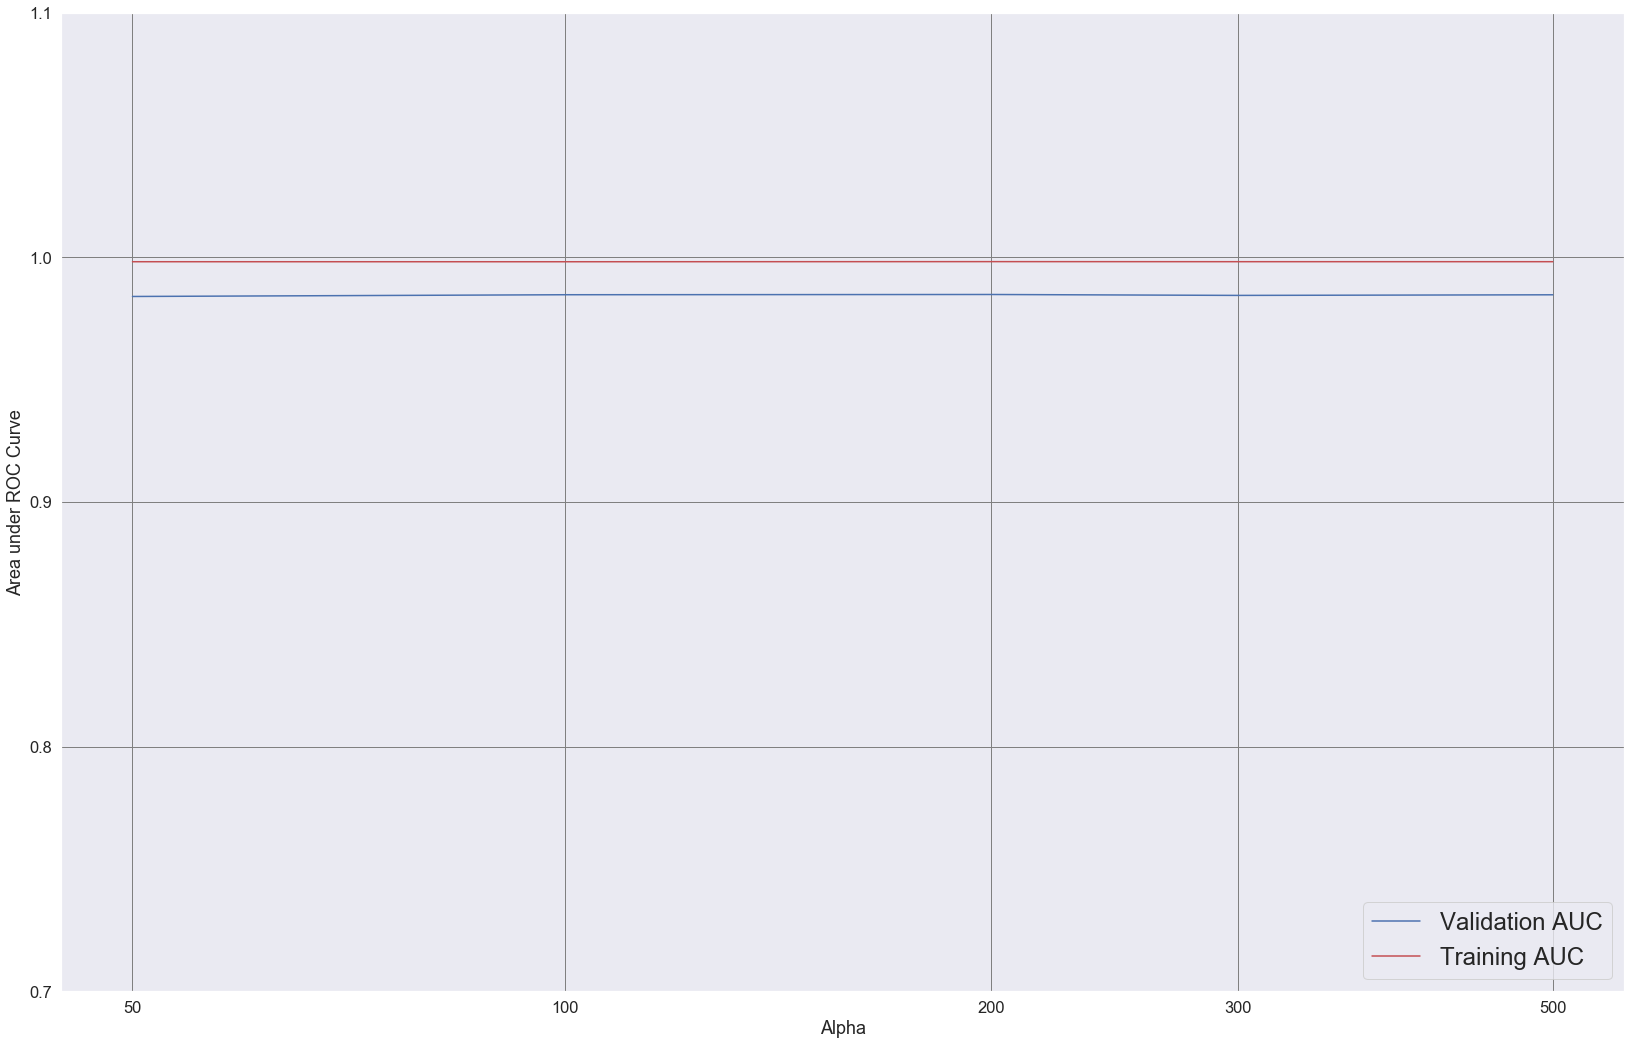

In [49]:
lambdalistorg = [50,100,200,300,500]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [50]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(2,optimal_t,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

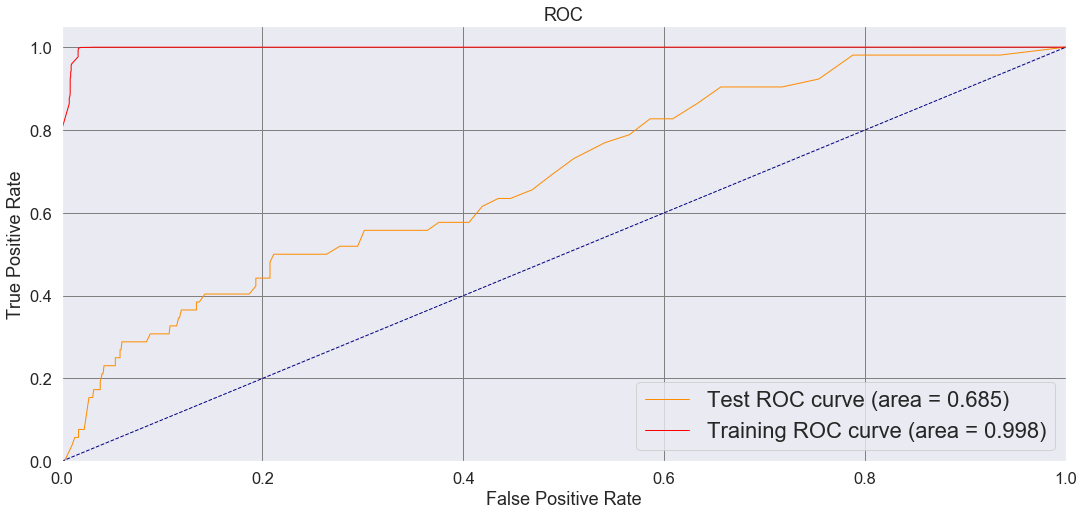

In [51]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


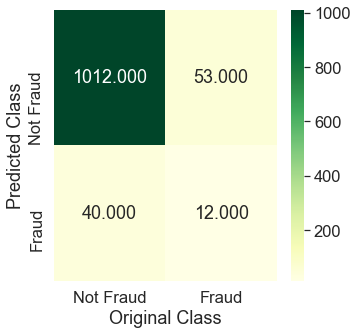

-------------------- Precision matrix  (Col Sum=1) --------------------


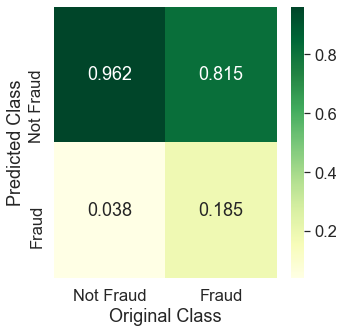

-------------------- Recall matrix  (Row Sum=1) - --------------------


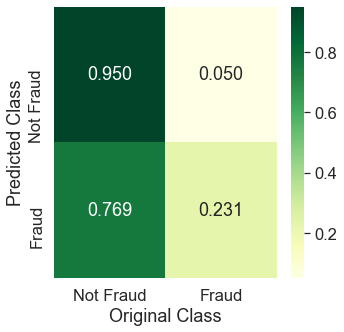

           Not Fraud     Fraud
Precision   0.961977  0.184615
Recall      0.950235  0.230769
F1-Score    0.956070  0.205128


In [52]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

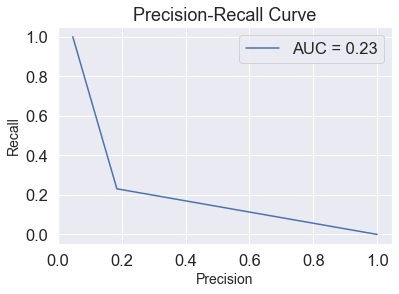

In [53]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 3. SVM

In [54]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(3,X_train, Y_train)

Best value of gamma =  0.01
0.923 (+/-0.012) for {'gamma': 0.001}
0.948 (+/-0.008) for {'gamma': 0.01}
0.934 (+/-0.011) for {'gamma': 0.1}
0.863 (+/-0.019) for {'gamma': 1}


<h3> 'Training - Validation' AUC </h2>

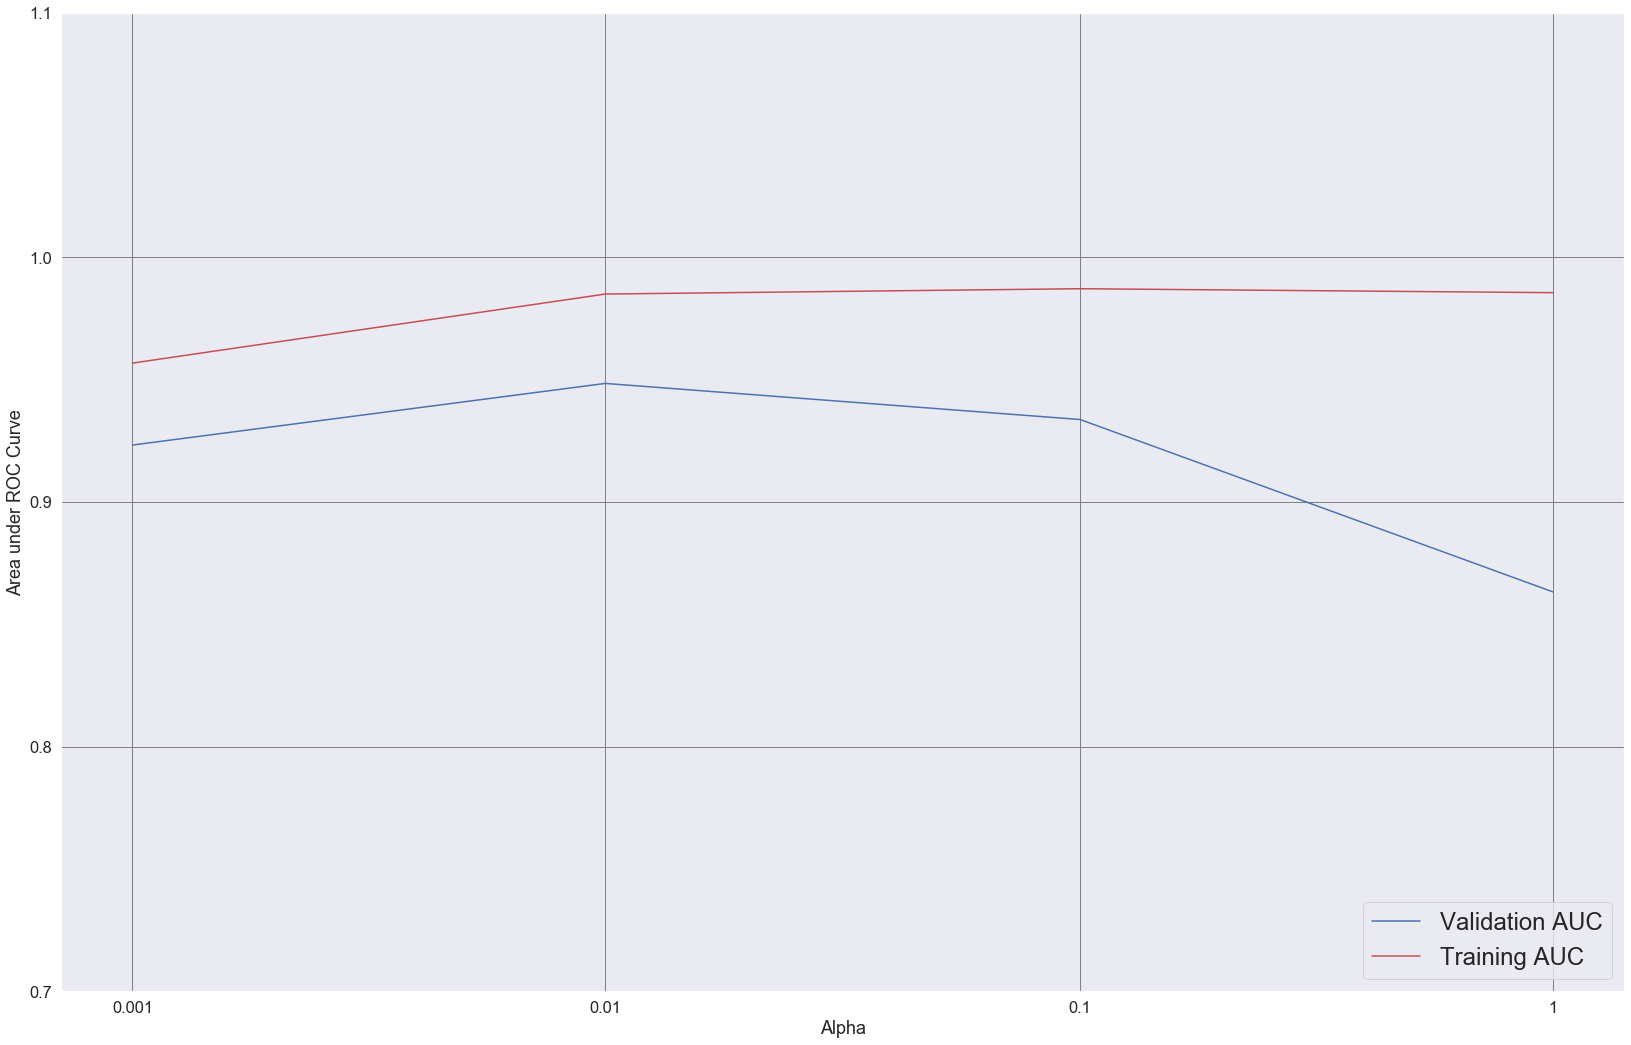

In [55]:
lambdalistorg = [0.001, 0.01, 0.1, 1]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [56]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(3,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

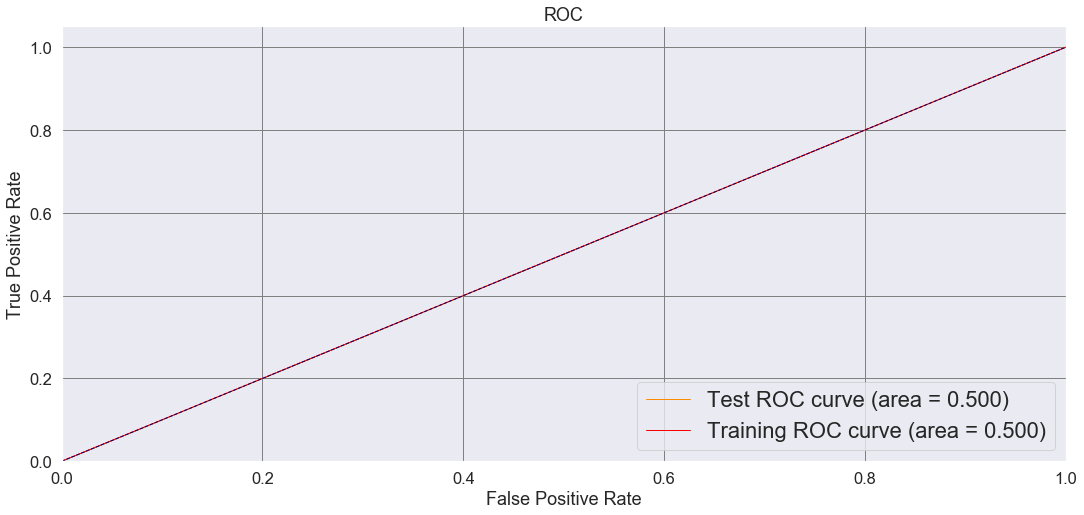

In [57]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


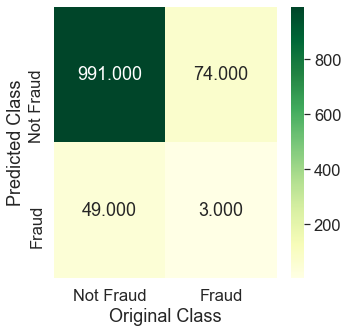

-------------------- Precision matrix  (Col Sum=1) --------------------


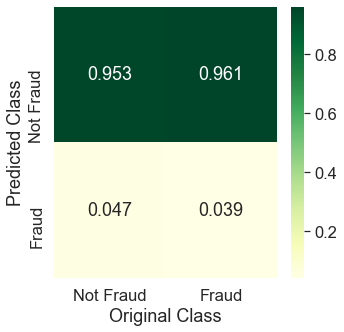

-------------------- Recall matrix  (Row Sum=1) - --------------------


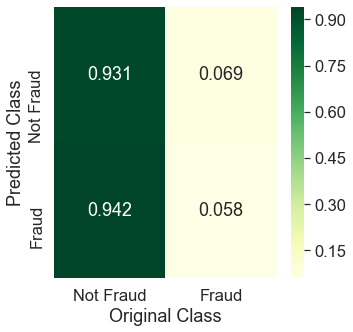

           Not Fraud     Fraud
Precision   0.952885  0.038961
Recall      0.930516  0.057692
F1-Score    0.941568  0.046512


In [58]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

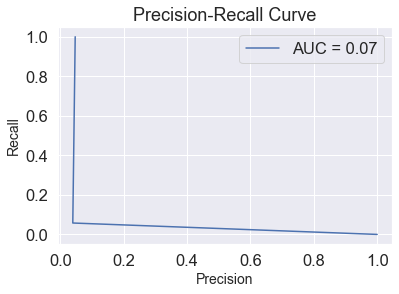

In [59]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 4. KNN

In [60]:
#Call the function to do cross validation (GridSearchCV) and return the scores correponding to different lamdba values
cv_scores_tr, cv_scores_cv, optimal_c= call_model(4,X_train, Y_train)

Best value of n_neighbors =  5
0.862 (+/-0.017) for {'n_neighbors': 1}
0.901 (+/-0.031) for {'n_neighbors': 3}
0.908 (+/-0.030) for {'n_neighbors': 5}
0.906 (+/-0.028) for {'n_neighbors': 7}
0.901 (+/-0.029) for {'n_neighbors': 9}
0.895 (+/-0.029) for {'n_neighbors': 11}
0.890 (+/-0.031) for {'n_neighbors': 13}
0.886 (+/-0.030) for {'n_neighbors': 15}
0.882 (+/-0.029) for {'n_neighbors': 17}


<h3> 'Training - Validation' AUC </h2>

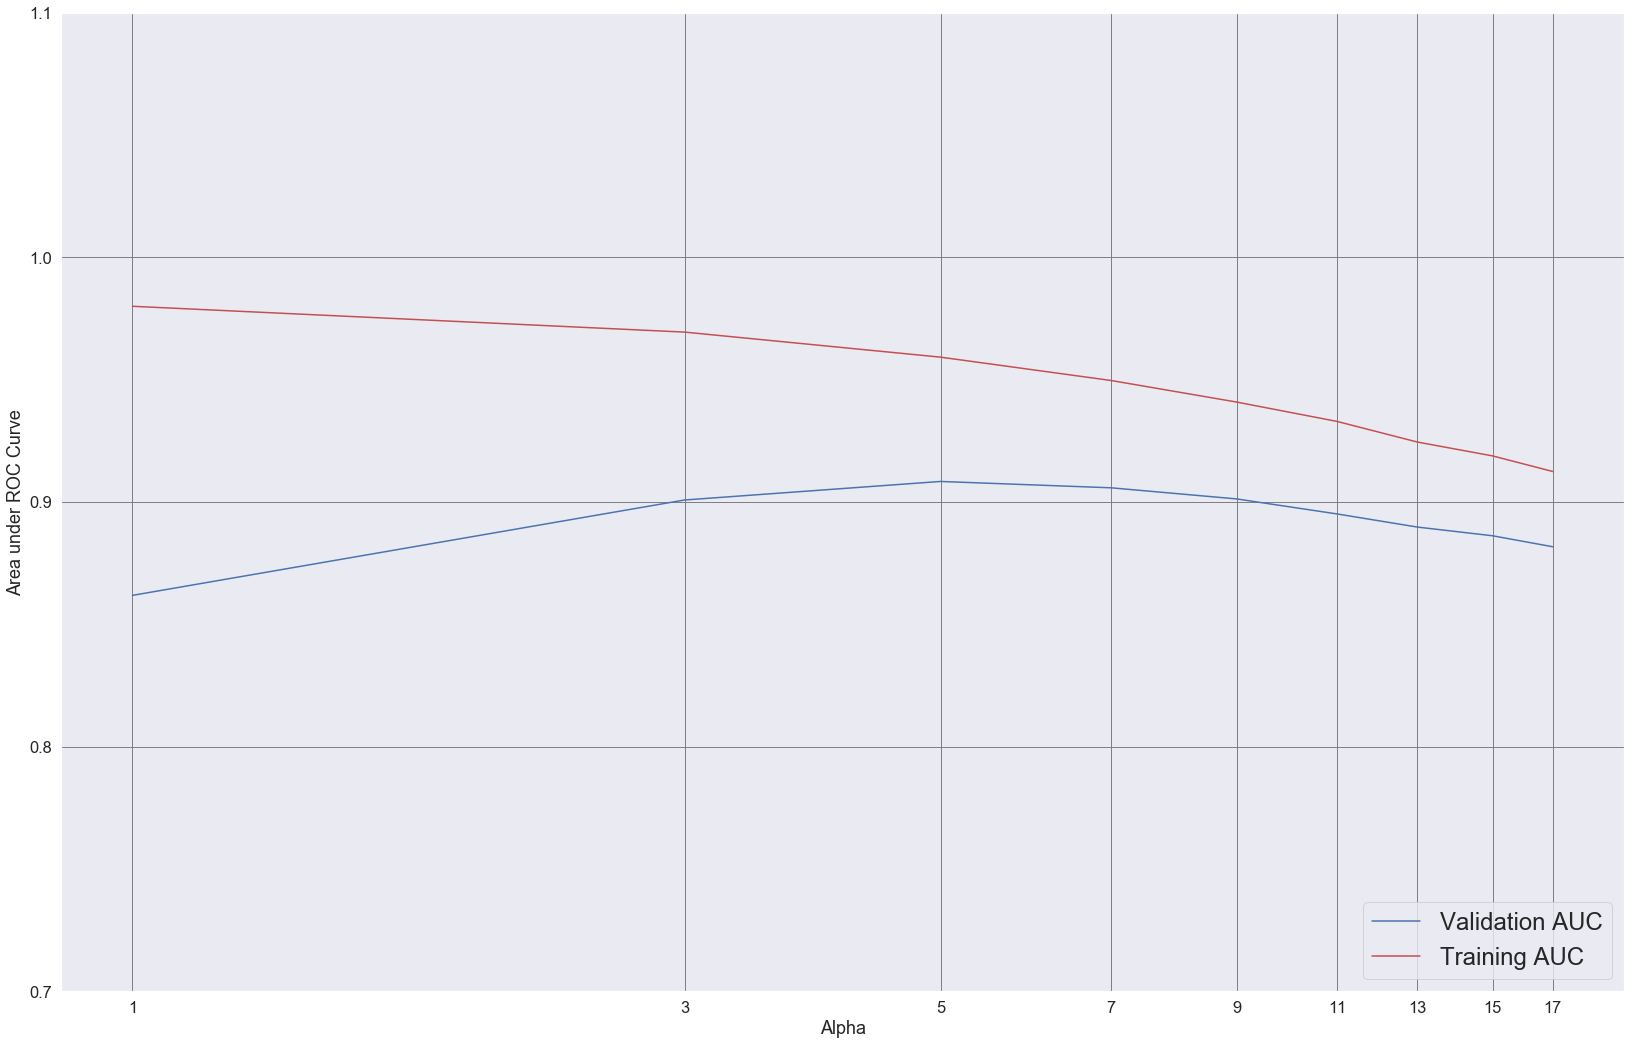

In [61]:
lambdalistorg = [1, 3, 5, 7, 9, 11, 13, 15, 17]
train_val_auc(cv_scores_tr, cv_scores_cv,lambdalistorg)

In [62]:
# Calculating the Test accuracy by calling the function test_acc
lrmodel,pred, fpr_ts, tpr_ts,fpr_tr, tpr_tr = test_acc(4,optimal_c,X_train,Y_train,X_test,Y_test)

<h3> ROC - AUC Curve </h3>

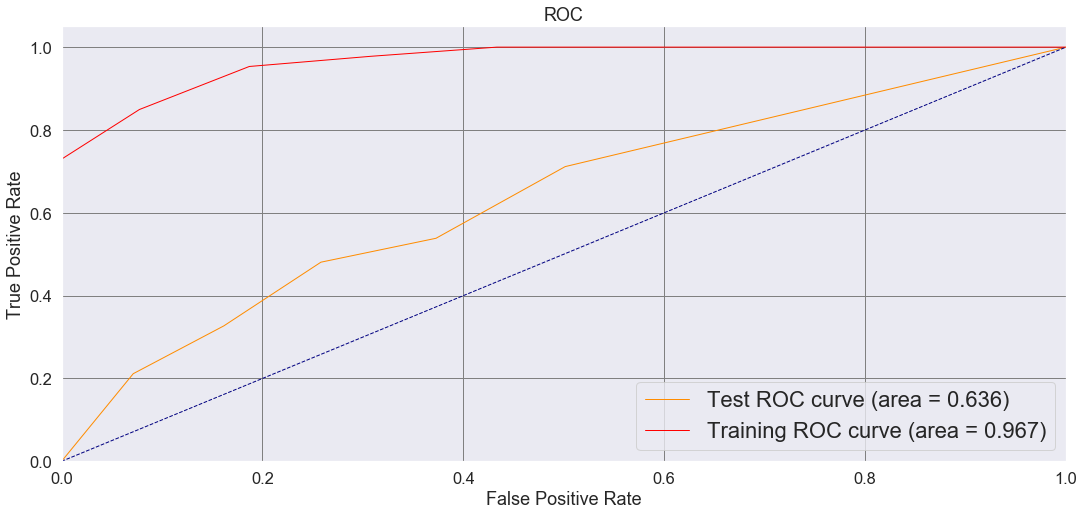

In [63]:
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

-------------------- Confusion matrix --------------------


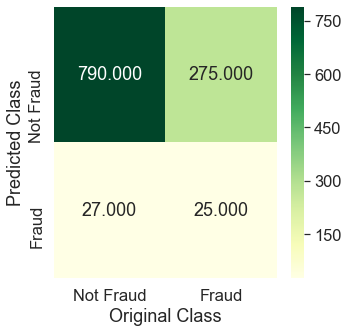

-------------------- Precision matrix  (Col Sum=1) --------------------


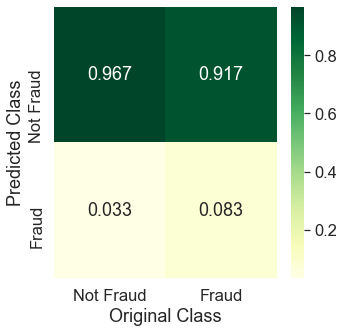

-------------------- Recall matrix  (Row Sum=1) - --------------------


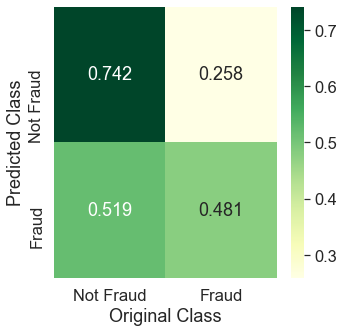

           Not Fraud     Fraud
Precision   0.966952  0.083333
Recall      0.741784  0.480769
F1-Score    0.839532  0.142045


In [64]:
conf_mat(pred,Y_test)

### Precision-Recall Curve

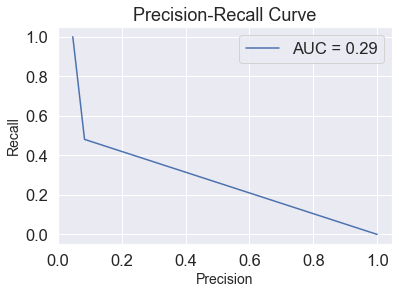

In [65]:
pr_recall_curve(Y_test, pred)

<h2> <font color = blue> 5. Neural Network

In [66]:
model = Sequential()
model.add(Dense(64, input_shape = (17,), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(1, activation = 'sigmoid'))
sgd = adam(lr = 0.001)
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1152      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [67]:
model.fit(X_train, Y_train, batch_size = 128, epochs = 100, verbose = 1)

ValueError: Error when checking input: expected dense_5_input to have shape (17,) but got array with shape (13,)

In [ ]:
results = model.evaluate(X_test, Y_test)


In [ ]:
print(model.metrics_names)
print(results)    

<h3> ROC - AUC Curve </h3>

In [ ]:
# predict the response Probabilities for Test data
pred_prob_ts = model.predict_proba(X_test)
# AUC for Test data
fpr_ts, tpr_ts, threshold = roc_curve(Y_test, pred_prob_ts)     

# predict the response Probabilities for Training data
pred_prob_tr = model.predict_proba(X_train)
# AUC for Training data
fpr_tr, tpr_tr, threshold = roc_curve(Y_train, pred_prob_tr)  
roc_train_test(fpr_ts, tpr_ts,fpr_tr, tpr_tr)

### Confusion Matrix

In [ ]:
Y_pred_cls = model.predict_classes(X_test, batch_size=200, verbose=0)
conf_mat(Y_pred_cls,Y_test)

### Precision-Recall Curve

In [ ]:
pr_recall_curve(Y_test, Y_pred_cls)

In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Oversampling","Model", "Test-AUC","Precision-Recall AUC"]

x.add_row(["No", "Logistic Regression", 0.925 ,0.54])
x.add_row(["No", "Random Forest", 0.924 ,0.54])
x.add_row(["No", "SVM",0.935 ,0.54])
x.add_row(["No", "KNN", 0.894,0.58])
x.add_row(["No", "Neural Network", 0.883 ,.54])
x.add_row(["Yes", "Logistic Regression", 0.935 ,0.62])
x.add_row(["Yes", "Random Forest", 0.925 ,0.56])
x.add_row(["Yes", "SVM", 0.901,0.52])
x.add_row(["Yes", "KNN", 0.885 ,0.59])
x.add_row(["Yes", "Neural Network", 0.943,0.58])
print(x)

## Applying the results in unlablled Test Data (Chosen MOdel : Nueral Networks WITH Oversampling)

In [ ]:
test_data.head()

In [ ]:
Test_Set = test_data[['Total Deductible Amount', 'Avg Deductible Amount',
       'Total Insurance Amount', 'Avg Insurance Amount', 'Avg Days Stayed',
       'Avg Days in claim', 'Avg Days Admission to Claim', 'Avg Age',
       'Avg Diagnosis Count', 'Avg Procedure Count', 'Avg Months PartA Cov',
       'Avg Months PartB Cov', 'Avg IP ReimbursementAmt',
       'Avg OP ReimbursementAmt', 'Avg IP DeductibleAmt',
       'Avg OP DeductibleAmt', 'Avg Disease Count']]

Test_Set = X_train_std.transform(Test_Set)

print(Test_Set.shape)

In [ ]:
Final_Prediction = model.predict_classes(Test_Set, batch_size=200, verbose=0)
print(Final_Prediction.shape)
test_data['Fraud'] = Final_Prediction
test_data.loc[test_data.Fraud == 1,'Fraud'] = 'Yes'
test_data.loc[test_data.Fraud == 0,'Fraud'] = 'No'
test_data.head()

In [ ]:
test_data.Fraud.value_counts()

In [ ]:
test_data[['Provider_ID','Fraud']].to_excel('Test_Data.xls', index=False)